# Study of the Variables on Digital Purchase Operations. 
# A Brasilian Model

Proyecto DS4A- E- COMMERCE

Participants:

- Sebastián Betancur Figueroa 
- Andres Felipe Cuintaco Rozo
- Cristian Camilo Correa
- Henry Puentes Gonzalez
- Jairo Castrellon Torres
- Emmanuel Gutierrez Jimenez
- Ernesto Ramirez Moncada



## Goals

In this case, we will suggest some improvement variables to Olist, an Brazilian E-commerce retailer using data science tools and Olist's dataset



## Introduction

E-commerce has experienced a major boom over the last decade due to the digital transformation in both the ways companies offer their products and how people acquire them. As a result, an exponential growth in the demand of product orders has been observed leading big and small sellers to adapt their production processes of marketing, production and product delivery to these new advances.

### Business Objective:

The board of Olist is looking for new insights that clarify what their customers (small and medium sellers) have to do to taking advantage of Olist's marketplace platform and increase their sales. This strategic decision is in line with the objective of increase in quantity and quality of sellers, and in the medium-term increase sales across the platform to increase company revenues.

#### Business Question:
What is the most important operational variables to increase customers' reviews score?

## Data Exploration

### Importing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy import stats
import unicodedata as unicode
from pingouin import pairwise_ttests
import snowflake.connector
import os
from scipy.stats import chi2_contingency
from sklearn import linear_model
from sklearn import model_selection
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from subprocess import check_call
import matplotlib.image as mpimg 
from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore")
pd.set_option('max_column',None)
%matplotlib inline

In [2]:
customers_dataset = pd.read_csv("Data/olist_customers_dataset.csv")
geolocation_dataset = pd.read_csv("Data/olist_geolocation_dataset.csv")
order_items_dataset = pd.read_csv("Data/olist_order_items_dataset.csv")
order_reviews_dataset = pd.read_csv("Data/olist_order_reviews_dataset.csv")
orders_dataset = pd.read_csv("Data/olist_orders_dataset.csv")
products_dataset = pd.read_csv("Data/olist_products_dataset.csv")
seller_dataset = pd.read_csv("Data/olist_sellers_dataset.csv")
product_category_name_translation = pd.read_csv("Data/product_category_name_translation.csv")


<img src=Olist_dataset.png width="400">

data set that contain the id, unique id, the zip code, the citya and the state of the costumer


In [17]:
df_orders = pd.merge(customers_dataset,orders_dataset, how = "left", left_on = "customer_id", right_on = "customer_id")
df_orders = pd.merge(df_orders,order_reviews_dataset, how = "left", left_on = "order_id", right_on = "order_id")
df_items=pd.merge(order_items_dataset,products_dataset,how='left',left_on='product_id',right_on='product_id')
df_items=pd.merge(df_items,product_category_name_translation,how='left',left_on='product_category_name',right_on='product_category_name')
df_items=pd.merge(df_items,seller_dataset,how='left',left_on='seller_id',right_on='seller_id')



In [18]:
## DB Conection

con = snowflake.connector.connect(
          user='CAMILOCBARRERA',
         password='Datos112020',
          account='ioa22652.us-east-1',
          warehouse='DS4A_WH',
          database='BRAZILIAN_ECOMMERCE_DB',
          )
def runQueryDF(sql):
    cursor=con.cursor()
    cursor.execute(sql)
    result=cursor.fetchall()
    df=pd.DataFrame(result)
    df.columns = [x.lower() for x in list(map(lambda t: t[0], cursor.description))]
    return df

### Data Cleansing and Features Engineering


In [19]:
#Clean special Portuguese characters in States and City names

geolocation_dataset['geolocation_city']=geolocation_dataset['geolocation_city'].apply(lambda x: unicode.normalize('NFKD',x).encode("ascii","ignore").decode("ascii"))
geolocation_dataset['geolocation_city'].unique()

array(['sao paulo', 'sao bernardo do campo', 'jundiai', ...,
       'floriano peixoto', 'erebango', 'santa cecilia do sul'],
      dtype=object)

In [20]:
#Drop any purchase outside of Brazil and assign an unique location to each zipcode

maxlat=5.25
minlat=-33.75
minlng=-74
maxlng=-29
geolocation_dataset=geolocation_dataset.drop(geolocation_dataset[(geolocation_dataset['geolocation_lat']>maxlat) | (geolocation_dataset['geolocation_lat']<minlat)|(geolocation_dataset['geolocation_lng']>maxlng) | (geolocation_dataset['geolocation_lng']<minlng)].index)
df_geo=geolocation_dataset.groupby('geolocation_zip_code_prefix').aggregate({'geolocation_lat':'mean','geolocation_lng':'mean'})
temp=geolocation_dataset.groupby(['geolocation_zip_code_prefix','geolocation_city','geolocation_state']).count().reset_index()

df_geo=df_geo.merge(temp[['geolocation_zip_code_prefix','geolocation_city','geolocation_state']],how='left',on='geolocation_zip_code_prefix')

In [21]:
#Load location information to each seller and buyer

df_orders=df_orders.merge(df_geo,how='left',right_on='geolocation_zip_code_prefix',left_on='customer_zip_code_prefix')
df_items=df_items.merge(df_geo,how='left',right_on='geolocation_zip_code_prefix',left_on='seller_zip_code_prefix')

In [22]:
#Calculate distance between seller and buyer for each purchase(order)

df_items=df_items.merge(df_orders[['order_id','geolocation_lat','geolocation_lng']],how='left',on='order_id')
import math as math
def distancia(row):
    lat1=row['geolocation_lat_x']
    lat2=row['geolocation_lat_y']
    lng1=row['geolocation_lng_x']
    lng2=row['geolocation_lng_y']
    R_earth=6371
    dlat=math.radians(lat2-lat1)
    dlng=math.radians(lng2-lng1)
    a= (math.sin(dlat/2))**2+math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*((math.sin(dlng/2))**2)
    c=2*math.atan2(math.sqrt(a),math.sqrt(1-a))
    return R_earth*c

df_items['distance']=df_items.apply(lambda x:distancia(x),axis=1)
df_items["LIMIT_DATE"] = pd.to_datetime(df_items["shipping_limit_date"])
df_orders['order_estimated_delivery_date']=pd.to_datetime(df_orders['order_estimated_delivery_date'])
temp=df_items.groupby('order_id').agg({'product_id':'count','LIMIT_DATE':'max','distance':'max'}).reset_index()
temp.columns=['order_id','Q_products','Shipping_due_date','Distance']
df_orders=df_orders.merge(temp,how='left',on='order_id')


In [24]:

#Calculate Fulfillment of delivery date according to expected delivery date

df_items["LIMIT_DATE"] = pd.to_datetime(df_items["shipping_limit_date"])
df_orders['order_estimated_delivery_date']=pd.to_datetime(df_orders['order_estimated_delivery_date'])
df_orders['order_delivered_customer_date']=pd.to_datetime(df_orders['order_delivered_customer_date'])
df_orders['Fulfill_date']= df_orders['order_delivered_customer_date']<df_orders['order_estimated_delivery_date']

In [26]:
#Calculate time elapsed between purchase and delivery

df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'], format='%Y/%m/%d %H:%M:%S')
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], format='%Y/%m/%d %H:%M:%S')
df_orders['time_duration'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp'])
df_orders['time_duration'] = df_orders['time_duration'].apply(lambda x: x.days)


In [28]:
#Building of Average Seller Score and Seller's Size in SQL

sql = """

WITH max_dates AS
(
select 
order_id, 
max(REVIEW_ANSWER_TIMESTAMP) REVIEW_ANSWER_TIMESTAMP
from order_reviews 
GROUP BY 1
)
,review AS
(
select 
rev.order_id,
rev.review_score
from order_reviews  rev
inner join max_dates  dat on rev.REVIEW_ANSWER_TIMESTAMP = dat.REVIEW_ANSWER_TIMESTAMP  AND rev.order_id = dat.order_id 
)
,o_sellers AS
(
select distinct
order_id,
seller_id
from order_items
group by 1,2
)

SELECT
seller_id,
avg(re.review_score) review_score,
count(distinct oi.order_id) as total_orders
FROM review re
inner join order_items oi on re.order_id = oi.order_id
group by 1 order by 2

"""

seller_review = runQueryDF(sql)

sql = """
select * from data_orders
"""
data_orders = runQueryDF(sql)
df_orders=df_orders.merge(data_orders[['order_id','seller_rating','seller_total_orders']],how='left',on='order_id')
df_orders.seller_rating=df_orders.seller_rating.apply(float)

In [29]:
# Dictionary to traslate states' acronyms
states = {
'AC':' Acre',
'AL':' Alagoas',
'AP':' Amapá',
'AM':' Amazonas',
'BA':' Bahia',
'CE':' Ceará',
'DF':' Distrito Federal',
'ES':' Espírito Santo',
'GO':' Goiás',
'MA':' Maranhão',
'MT':' Mato Grosso',
'MS':' Mato Grosso do Sul',
'MG':' Minas Gerais',
'PA':' Pará',
'PB':' Paraíba',
'PR':' Paraná',
'PE':' Pernambuco',
'PI':' Piauí',
'RJ':' Rio de Janeiro',
'RN':' Rio Grande do Norte',
'RS':' Rio Grande do Sul',
'RO':' Rondônia',
'RR':' Roraima',
'SC':' Santa Catarina',
'SP':' São Paulo',
'SE':' Sergipe',
'TO':' Tocantins',
}

### Main dataframes / Features dictionary

"df_orders" is the main dataframe, it cointaind all the information about each purchase that was performed by a buyer. An order can cointain several items and they're registered in "df_items" dataframe.

#### df_orders variables:

- *customer_id*: Identifies each buyer
- *customer_zip_code_prefix*: Zip code where the buyer is located
- *customer city*: Buyer's city
- *customer state*: Buyer's state
- *order_id*: Identifier of the purchase (PRIMARY KEY)
- *order_status*: Show the stage of the purchase in the system; could be: delivered, cancel, approved, etc
- *order_purchase_timestamp*: Date of the purchase
- *order_estimated_delivery_date*: Due date to deliver the purchase
- *order_delivered_customer_date*: Date of real delivery
- *review_score*: Score give by the buyer to the purchase (OBJECTIVE VARIABLE)
- *review_comment_title*: Title of the buyer's review about the order
- *review_comment_message*: Full message of the buyer's review about the order

Featured variables:
- *geolocation_lat & geolocation_lng*: Buyer's geo coordinates
- *Q_products*: Quantity of items in the purchase
- *Distance*: Distance in km between Buyer and Seller
- *Fulfill date*: Boolean that indicates if the due delivery date was fulfill
- *time duration*: Elapsed time between Purchase and Delivery
- *seller_rating*: Average of all the order dispatched by the seller
- *seller_total_orders*: Number of order dispatched by the seller (proxy od seller's size)


In [30]:
df_orders.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,Q_products,Shipping_due_date,Distance,Fulfill_date,time_duration,seller_rating,seller_total_orders
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,14409.0,-20.498489,-47.396929,franca,SP,1.0,2017-05-22 15:22:12,348.770656,True,8.0,3.484725,982.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,9790.0,-23.727992,-46.542848,sao bernardo do campo,SP,1.0,2018-01-18 20:58:32,413.831736,True,16.0,4.244444,45.0


#### df_items variables:

- *order_id*: Identifier of the purchase (FOREIGN KEY)
- *product_id *: Identifier of the product included in the purchase
- *seller id*: Identifier of the seller of each item (Each purchase could have several sellers)
- *shipping_limit_date*: Due date to ship the order
- *price*: price of each item
- *product_category_name*: Classification of items in categories
- *seller_zip_code_prefix*: Zip code where the buyer is located


Featured variables:
- *geolocation_lat_x & geolocation_lng_x*: Buyer's geo coordinates
- *geolocation_lat_y & geolocation_lng_y*: Seller's geo coordinates
- *distance*: Distance in km between Buyer and Seller

In [31]:
df_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat_x,geolocation_lng_x,geolocation_city,geolocation_state,geolocation_lat_y,geolocation_lng_y,distance,LIMIT_DATE
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,27277,volta redonda,SP,27277.0,-22.496953,-44.127492,volta redonda,RJ,-21.762775,-41.309633,301.504681,2017-09-19 09:45:35
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop,3471,sao paulo,SP,3471.0,-23.565096,-46.518565,sao paulo,SP,-20.220527,-50.903424,585.563937,2017-05-03 11:05:13


### Variable Exploration

Let's start with variable exploration, the final objective is to find relevant variables in athe available dataset that infuence in the review score gived by the customer for each purchase


<AxesSubplot:xlabel='review_score'>

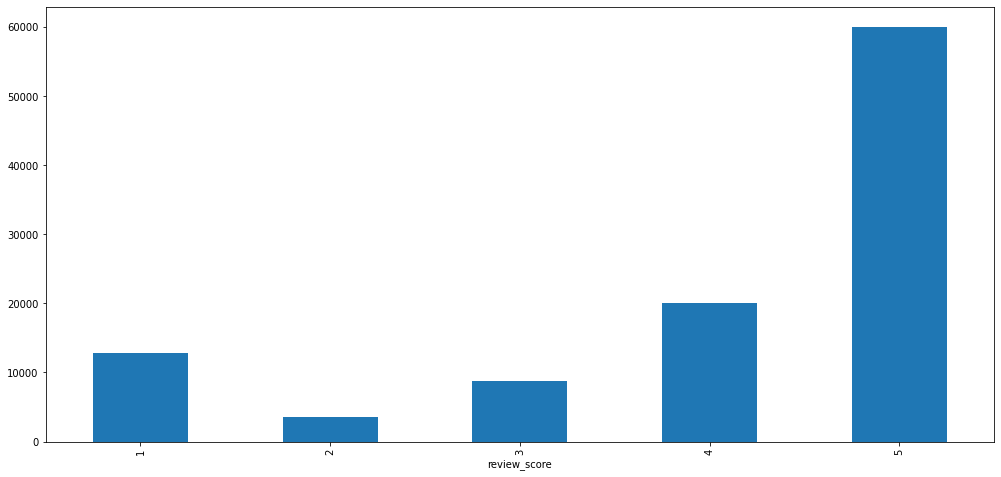

In [32]:
#Distribution of Reviews

plt.figure(figsize=(17,8))
df_orders.groupby('review_score')['order_id'].count().plot.bar()

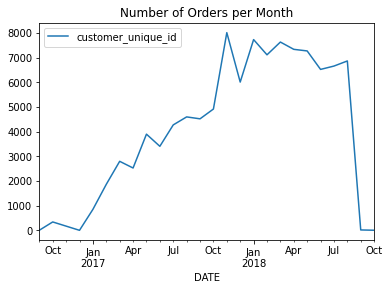

In [33]:
#Evolution of sales across time

df_orders["DATE"] = pd.to_datetime(df_orders["order_purchase_timestamp"])
df_orders["DATE"] = df_orders["DATE"].dt.to_period(freq = "M")
orders_by_month = df_orders.groupby('DATE')['customer_unique_id'].count().reset_index(drop = False)
_=orders_by_month.plot(x= "DATE",y="customer_unique_id",title="Number of Orders per Month")   

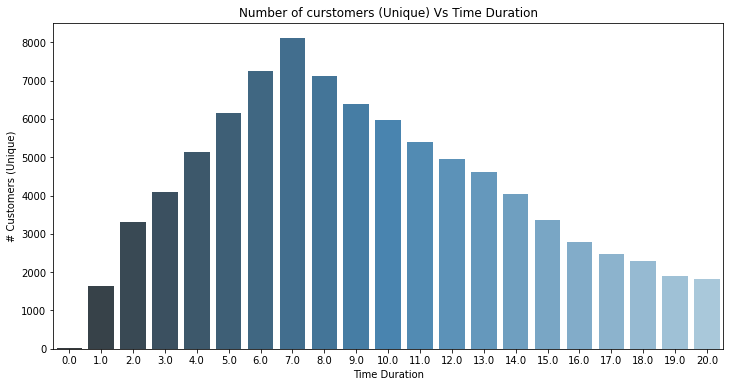

In [34]:
#Distribution of orders' duration (Time elapsed between purchase and delivery)

df_subset= df_orders[df_orders.time_duration <= 20]
df_by_duration = df_subset.groupby(['time_duration'])['customer_unique_id'].count().reset_index(drop = False)
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.barplot(ax=ax
                , x="time_duration"
                , y="customer_unique_id"
                , data=df_by_duration
                , palette="Blues_d"                
               )
_=g.set(xlabel = 'Time Duration', ylabel = '# Customers (Unique)', title="Number of curstomers (Unique) Vs Time Duration")

In [37]:
#Top sell Items' categories

df_products = df_items.groupby('product_category_name_english')['order_id'].count().reset_index(drop = False)
df_products = df_products.sort_values(by = 'order_id', ascending = False).reset_index(drop = True)
top_products = df_products.head(10)
top_products

,product_category_name_english,order_id
0,bed_bath_table,11746
1,health_beauty,10612
2,sports_leisure,9647
3,furniture_decor,8965
4,computers_accessories,8283
5,housewares,7295
6,watches_gifts,6358
7,telephony,4874
8,auto,4656
9,garden_tools,4575


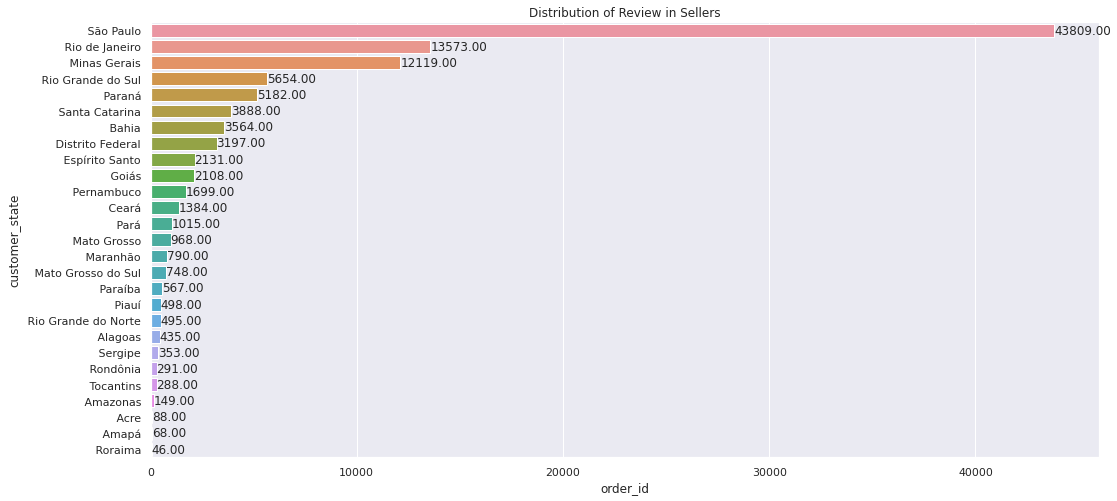

In [38]:
#Geographical distribution of sellers

plt.figure(figsize=(17,8))
a = df_orders.groupby('customer_state')['order_id'].count().sort_values(ascending=False).to_frame().reset_index()
a['customer_state'] = a['customer_state'].map(states)
a.head()

sns.set_color_codes("pastel")

sns.set(rc={'figure.figsize':(15,7)})
ax = sns.barplot(x="order_id", y="customer_state", data=a,label="Total")
ax.set(title='Distribution of Review in Sellers')

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

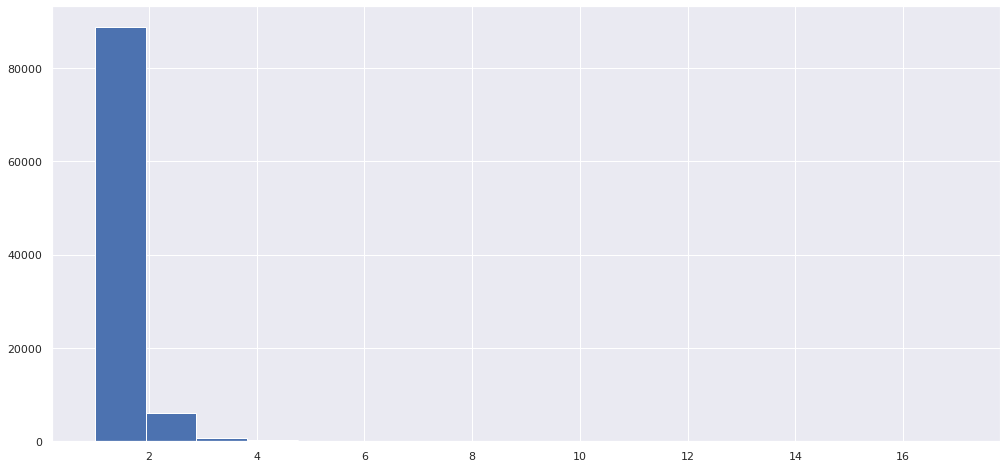

In [39]:
#Quantity of ordes per buyer (recurrent buyers)

plt.figure(figsize=(17,8))
orders_client=df_orders.groupby('customer_unique_id')['order_id'].count().sort_values(ascending=False)
_=plt.hist(orders_client,17)

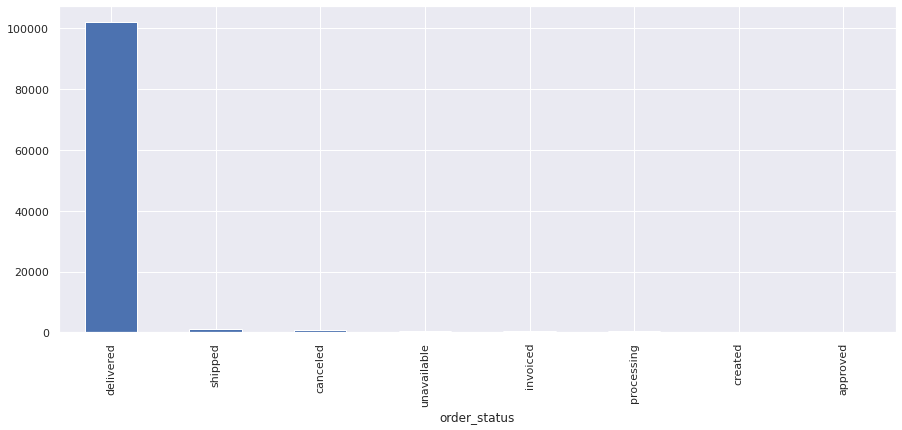

In [42]:
#Status of the orders

_=df_orders.groupby('order_status')['order_id'].count().sort_values(ascending=False).plot.bar()

### Checking interaction between Review Score and the other variables

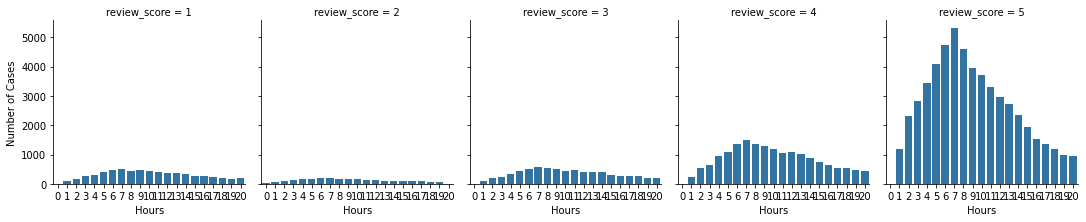

In [35]:
#Distribution of duration for each review score category

df_subset= df_orders[df_orders.time_duration <= 20]
df_subset.time_duration = df_subset.time_duration.astype(int)
df_by_duration = df_subset.groupby(['time_duration','review_score'])['customer_unique_id'].count().reset_index(drop = False)
g = sns.FacetGrid(df_by_duration, col = 'review_score')
g.set_xticklabels(fontsize=10)
g.map_dataframe(sns.barplot, x= 'time_duration', y = 'customer_unique_id')
_=g.set_axis_labels("Hours", "Number of Cases")

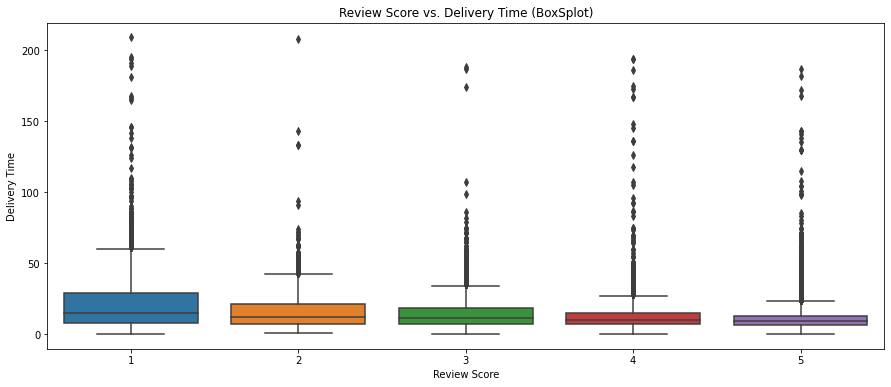

In [36]:
#Boxplot of time duration for review scores

plt.figure(figsize=(15,6))
sns.boxplot(y = 'time_duration', x='review_score', data = df_orders)
#Modificación de Emmanuel para embellecer
#Inicio(4)
title_string = "Review Score vs. Delivery Time (BoxSplot)" 
plt.ylabel("Delivery Time")
plt.xlabel("Review Score")
#Fin(4)
_=plt.title(title_string)

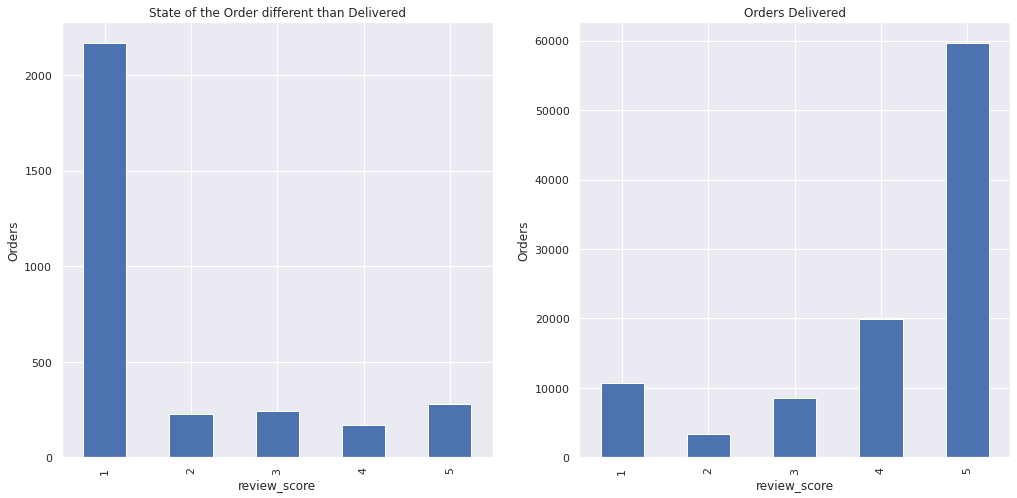

In [43]:
#How change the review with the order status?

plt.figure(figsize=(17,8))
plt.subplot(121)
_=df_orders[df_orders.order_status!='delivered'].groupby('review_score')['order_id'].count().plot.bar()
plt.ylabel("Orders")
plt.xlabel="Review Score"
plt.title("State of the Order different than Delivered")
plt.subplot(122)
plt.ylabel("Orders")
plt.xlabel="Review Score"
plt.title("Orders Delivered")
_=df_orders[df_orders.order_status=='delivered'].groupby('review_score')['order_id'].count().plot.bar()

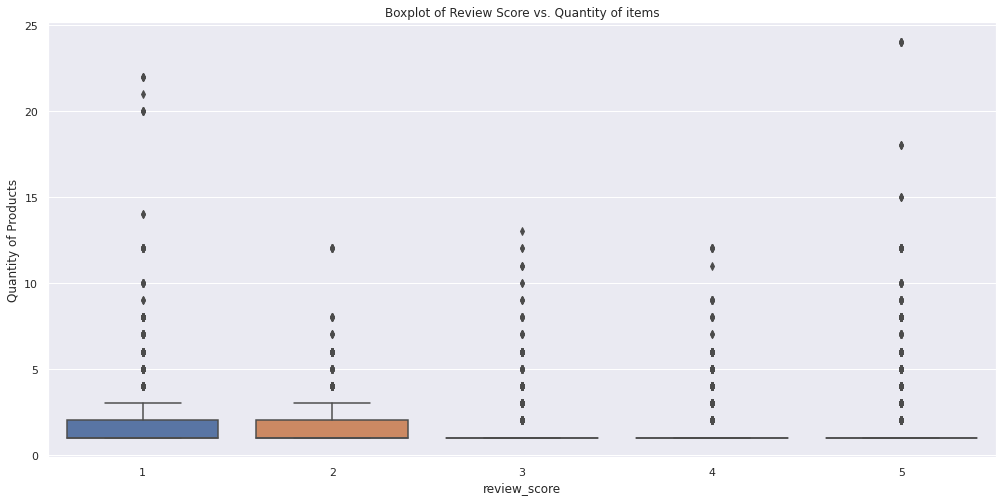

In [44]:
#Box Plot for Quantity of items in the order vs review score

plt.figure(figsize=(17,8))
sns.boxplot(y = 'Q_products', x='review_score', data = df_orders)
title_string = "Boxplot of Review Score vs. Quantity of items" 
plt.ylabel("Quantity of Products")
_=plt.title(title_string)

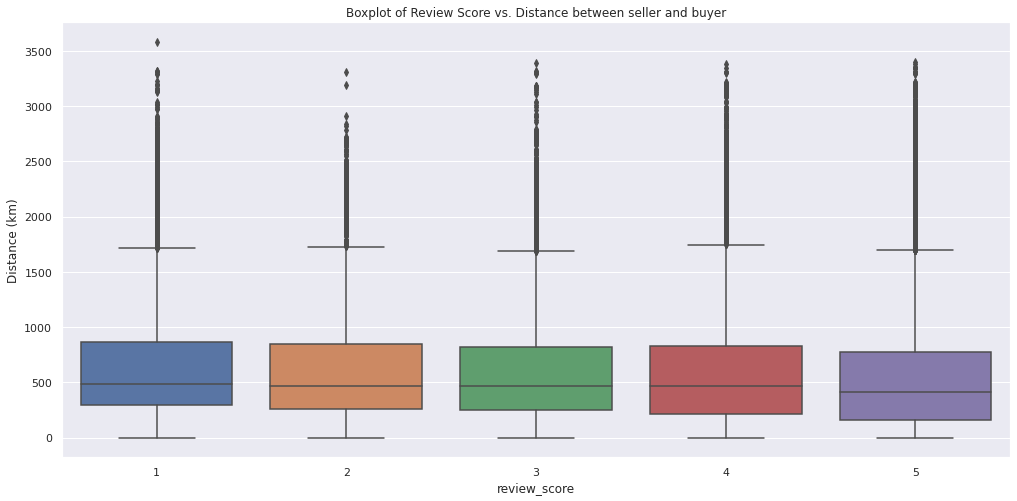

In [45]:
#Boxplot of distance between seller and buyer vs review score
plt.figure(figsize=(17,8))
sns.boxplot(y = 'Distance', x='review_score', data = df_orders)
title_string = "Boxplot of Review Score vs. Distance between seller and buyer" 
plt.ylabel("Distance (km)")
plt.xlabel="Review Score"
_=plt.title(title_string)

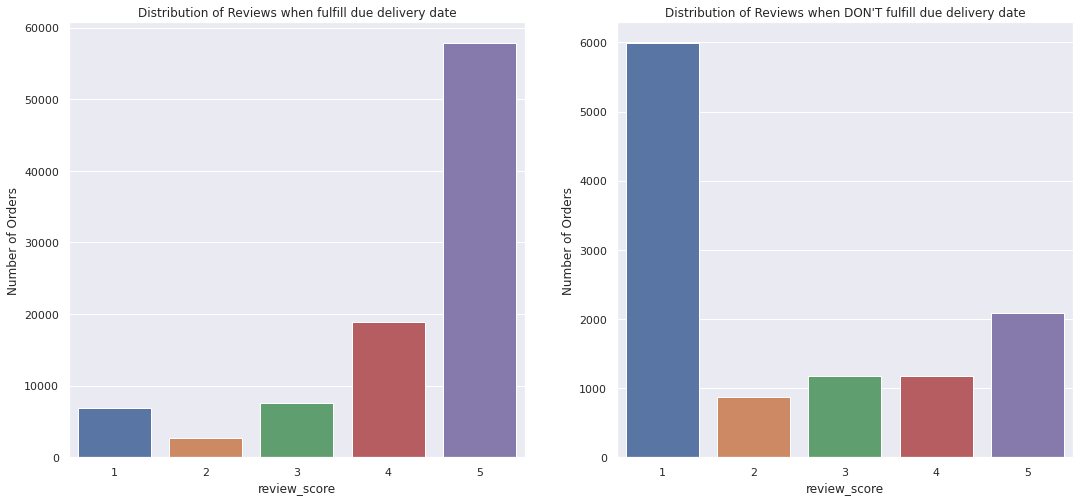

In [48]:
# Fulfillment of the due delivery date vs Review Score

fig, ax=plt.subplots(1,2, figsize=(18,8))
_=df_orders[df_orders.Fulfill_date==True].groupby('review_score')['order_id'].count().reset_index(drop = False)
_2=df_orders[df_orders.Fulfill_date==False].groupby('review_score')['order_id'].count().reset_index(drop = False)

graph1 = sns.barplot(y='order_id', x='review_score', data=_, ax=ax[0])
graph1.set_title("Distribution of Reviews when fulfill due delivery date")
graph1.set_ylabel("Number of Orders")
graph2 = sns.barplot(y='order_id', x ='review_score', data = _2, ax=ax[1])
graph2.set_title("Distribution of Reviews when DON'T fulfill due delivery date")
_=graph2.set_ylabel("Number of Orders")


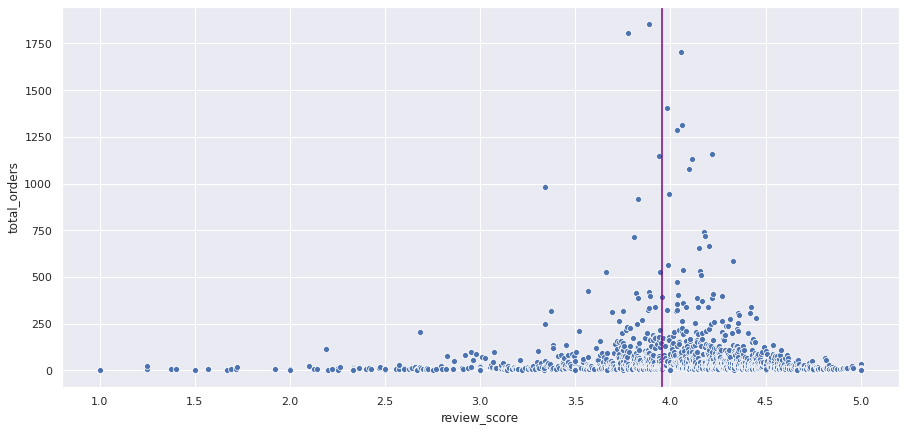

In [64]:
# Seller rating and orders 

sns.set(rc={'figure.figsize':(15,7)})
ax=sns.scatterplot(data=seller_review, x="review_score", y="total_orders")
plt.title="Scatter of Seller Average Score and Seller total sales"
_=plt.axvline(seller_review['review_score'].mean(), color='purple', label='Mean') ##Add Mean of review sellers


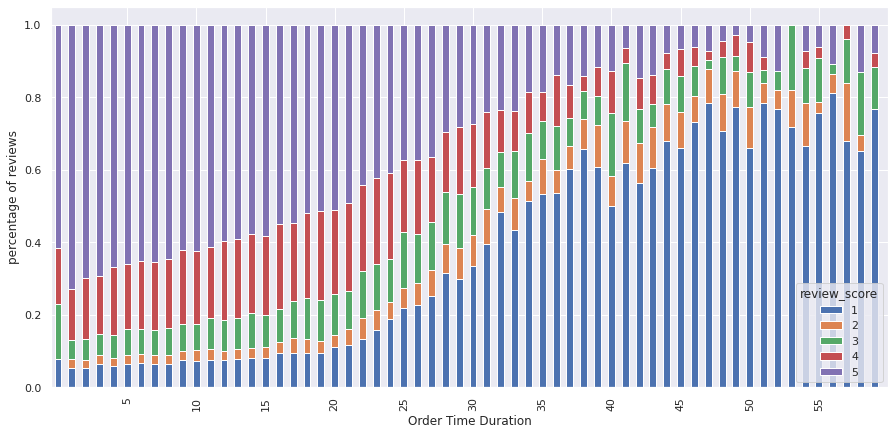

In [68]:
#Distribution of reviews when time duration increases

temp=df_orders.groupby(['time_duration','review_score'])['order_id'].count().reset_index()
temp2=temp.pivot_table(index=('time_duration'),columns=('review_score'),values='order_id').reset_index()
temp2=temp2.fillna(0)
temp2=temp2[(temp2.time_duration<60)]
temp2['Suma']=temp2[1]+temp2[2]+temp2[3]+temp2[4]+temp2[5]
x= temp2[[1,2,3,4,5]].div(temp2.Suma, axis=0)
h = x.plot(kind='bar',stacked=True, xlabel = 'Order Time Duration')

g = (g.set_axis_labels().set(xlim = (3),ylim = (0,100)))
plt.title='Order time Duration vs Review Costumer'
plt.ylabel('percentage of reviews')
_=plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60])

In [72]:
corr_mat  = df_orders.corr()
corr_mat

,customer_zip_code_prefix,review_score,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,Q_products,Distance,Fulfill_date,time_duration
customer_zip_code_prefix,1.000000,-0.021832,1.000000,0.133683,-0.309541,0.022002,0.487431,-0.025714,0.269650
review_score,-0.021832,1.000000,-0.021997,-0.042555,-0.051207,-0.092941,-0.061631,0.364878,-0.334243
geolocation_zip_code_prefix,1.000000,-0.021997,1.000000,0.133683,-0.309541,0.022430,0.487431,-0.025647,0.269903
geolocation_lat,0.133683,-0.042555,0.133683,1.000000,0.437228,0.011182,0.707289,-0.054904,0.255281
geolocation_lng,-0.309541,-0.051207,-0.309541,0.437228,1.000000,-0.021773,0.218023,-0.074729,0.110979
Q_products,0.022002,-0.092941,0.022430,0.011182,-0.021773,1.000000,-0.008704,0.010403,-0.012404
Distance,0.487431,-0.061631,0.487431,0.707289,0.218023,-0.008704,1.000000,-0.067575,0.389296
Fulfill_date,-0.025714,0.364878,-0.025647,-0.054904,-0.074729,0.010403,-0.067575,1.000000,-0.591866
time_duration,0.269650,-0.334243,0.269903,0.255281,0.110979,-0.012404,0.389296,-0.591866,1.000000


# Hypothesis testing


 1. T-student test by pairs for order status vs Order Review

In [69]:
mod = ols('review_score ~ order_status', data=df_orders).fit()  
aov_table = sm.stats.anova_lm(mod, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
order_status,16972.836047,7.0,1409.318492,0.0
Residual,180819.727055,105099.0,NaN,NaN


In [70]:
gb = df_orders.groupby(['order_status'])
group_names = df_orders["order_status"].unique()
print("\t\t\tstatistic\t\tpvalue")
len(group_names)
for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        group1 = gb[["review_score"]].get_group(group_names[i])
        group2 = gb[["review_score"]].get_group(group_names[j])
        stat, pvalue = stats.ttest_ind(group1, group2, equal_var = False)
        print(group_names[i] + " vs. " + group_names[j] + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

			statistic		pvalue
delivered vs. canceled	42.956413769753844	6.874498637903272e-193
delivered vs. invoiced	35.16696546869385	2.479819923132263e-112
delivered vs. shipped	49.51269315960058	2.1966751927946995e-290
delivered vs. processing	63.535742187924974	1.2742926086617124e-183
delivered vs. unavailable	56.216762144254	2.245855926182502e-249
delivered vs. approved	1.0822510981756701	0.47486380358973346
delivered vs. created	2.9041901384894078	0.04393024378006801
canceled vs. invoiced	1.6984552539251974	0.08987244829664255
canceled vs. shipped	-3.0329945214986087	0.0024658453878107483
canceled vs. processing	7.594923311649236	7.450587520392669e-14
canceled vs. unavailable	3.623686309564191	0.0003020921067348542
canceled vs. approved	-0.4673899101460297	0.7214967763467373
canceled vs. created	-0.001918716190578096	0.998560173388291
invoiced vs. shipped	-4.369210053185275	1.4790458766283999e-05
invoiced vs. processing	4.586028062823807	5.6158839095309565e-06
invoiced vs. unavailable	1.

In [71]:
pairwise_results = pairwise_ttests(dv='review_score', between = ['order_status'], padjust='bonf', data=df_orders)
pairwise_results[(pairwise_results['A']=="delivered")]

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,order_status,delivered,canceled,False,True,42.956414,656.540703,two-sided,6.874499e-193,1.924860e-191,bonf,inf,1.771521
1,order_status,delivered,invoiced,False,True,35.166965,322.190370,two-sided,2.479820e-112,6.943496e-111,bonf,6.338e+264,1.887016
2,order_status,delivered,shipped,False,True,49.512693,1180.701051,two-sided,2.196675e-290,6.150691e-289,bonf,inf,1.611219
3,order_status,delivered,processing,False,True,63.535742,320.320853,two-sided,1.274293e-183,3.568019e-182,bonf,inf,2.180184
4,order_status,delivered,unavailable,False,True,56.216762,638.172506,two-sided,2.245856e-249,6.288397e-248,bonf,inf,1.968879
5,order_status,delivered,approved,False,True,1.082251,1.000015,two-sided,4.748638e-01,1.000000e+00,bonf,0.719,1.237350
6,order_status,delivered,created,False,True,2.904190,4.000211,two-sided,4.393024e-02,1.000000e+00,bonf,9.4,1.770878


2. Chi-Square test for time duration (time elapsed between purchase and delivery) vs Order Review

In [72]:
chi_time_duration=pd.crosstab(df_orders['time_duration'],df_orders['review_score'])
g, p, dof, expctd = chi2_contingency(chi_time_duration)
print("p-value of Chi-square test for Time between Purchase and Delivery vs. Single Order Review Score =", p)
chi_time_duration

p-value of Chi-square test for Time between Purchase and Delivery vs. Single Order Review Score = 0.0


3. Chi-Square test for Seller average rating vs Order Review

In [73]:
chi_seller_rating=pd.crosstab(df_orders['seller_rating'],df_orders['review_score'])
g, p, dof, expctd = chi2_contingency(chi_seller_rating)
print("p-value of Chi-square test for Seller Average Rating vs. Single Order Review Score =", p)
chi_seller_rating

p-value of Chi-square test for Seller Average Rating vs. Single Order Review Score = 0.0


review_score,1,2,3,4,5
seller_rating,,,,,
1.000000,209,0,0,0,2
1.250000,22,2,0,0,1
1.400000,4,0,1,0,0
1.500000,8,5,1,0,0
1.571429,5,0,2,0,0
...,...,...,...,...,...
4.909091,0,0,0,3,31
4.923077,0,0,0,2,25
4.947368,0,0,0,1,20


4. Chi-Square test for Seller Size vs Order Review

In [74]:
chi_seller_size=pd.crosstab(df_orders['seller_total_orders'],df_orders['review_score'])
g, p, dof, expctd = chi2_contingency(chi_seller_size)
print("p-value of Chi-square test for Order Status vs. Single Order Review Score =", p)
chi_seller_size

p-value of Chi-square test for Order Status vs. Single Order Review Score = 5.551918676106786e-254


review_score,1,2,3,4,5
seller_total_orders,,,,,
1.0,131,19,41,79,319
2.0,157,18,60,135,370
3.0,121,22,44,116,378
4.0,77,15,51,127,386
5.0,84,19,45,129,465
...,...,...,...,...,...
1314.0,124,47,123,279,807
1404.0,164,45,106,267,872
1706.0,213,61,179,313,1069


 5.3. Chi-Square test for Quantity of products in the order vs Order Review

In [75]:
chi_Q_products=pd.crosstab(df_orders['Q_products'],df_orders['review_score'])
g, p, dof, expctd = chi2_contingency(chi_Q_products)
print("p-value of Chi-square test for Quantity of Products vs. Single Order Review Score =", p)
chi_Q_products

p-value of Chi-square test for Quantity of Products vs. Single Order Review Score = 0.0


review_score,1,2,3,4,5
Q_products,,,,,
1.0,8427,2431,6812,16449,49207
2.0,2649,715,1414,2616,8015
3.0,536,144,275,552,1571
4.0,339,96,135,255,655
5.0,71,18,16,36,81
6.0,121,35,53,92,202
7.0,21,3,5,2,11
8.0,35,6,9,7,44
9.0,2,0,3,9,16


6. T-student test to compare means for fulfill/not fulfill due delivery date vs Order Review

In [76]:
statistic, pvalue = stats.ttest_ind(df_orders[df_orders.Fulfill_date==False].review_score,df_orders[df_orders.Fulfill_date==True].review_score, equal_var=False)
print("p-value of t-student test for fulfill due delivery date vs. Single Order Review Score =", pvalue)

p-value of t-student test for fulfill due delivery date vs. Single Order Review Score = 0.0


# Models

In [80]:
model1 = 'review_score~time_duration + Fulfill_date + seller_rating + Q_products'
lm1   = sm.ols(formula = model1, data = df_orders).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     6173.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:23:37   Log-Likelihood:            -1.6142e+05
No. Observations:              102023   AIC:                         3.229e+05
Df Residuals:                  102018   BIC:                         3.229e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5208 

In [81]:
Y=df_orders['review_score']
X=df_orders[['time_duration','Fulfill_date','seller_rating','Q_products','seller_total_orders']]
X

,time_duration,Fulfill_date,seller_rating,Q_products,seller_total_orders
0,8.0,True,3.484725,1.0,982
1,16.0,True,4.244444,1.0,45
2,26.0,False,3.484725,1.0,982
3,14.0,True,3.484725,1.0,982
4,11.0,True,3.804540,1.0,1806
...,...,...,...,...,...
102018,6.0,True,4.433333,1.0,90
102019,7.0,True,3.783784,1.0,37
102020,30.0,False,3.545455,1.0,11
102021,12.0,True,4.122792,1.0,1132


In [82]:

tree.DecisionTreeRegressor
decision_tree = tree.DecisionTreeRegressor(
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 4,
                                            )

In [83]:
decision_tree.fit(X, Y)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, min_samples_split=20)

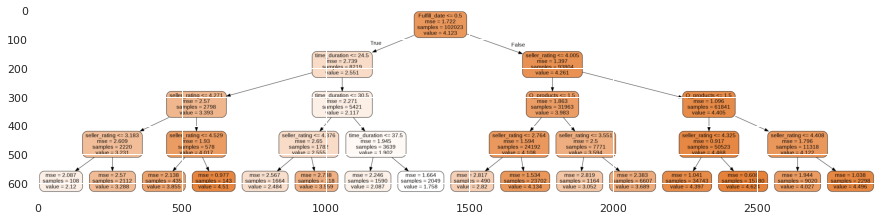

In [100]:
# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 7,
                              impurity = True,
                              feature_names = list(X),
                              class_names = ['1','2','3','4','5'],
                              rounded = True,
                              filled= True )

# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
img = mpimg.imread('tree1.png') 
#PImage("tree1.png")
plt.imshow(img) 

In [ ]:
dataframe=X=df_orders[['review_score','time_duration','Fulfill_date','seller_rating','Q_products','seller_total_orders']]

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(dataframe))
depth_range = range(1, max_attributes + 1)
 
# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth)
    for train_fold, valid_fold in cv.split(dataframe):
        f_train = dataframe.loc[train_fold] 
        f_valid = dataframe.loc[valid_fold] 
 
        model = tree_model.fit(X = f_train.drop(['review_score'], axis=1), 
                               y = f_train["review_score"]) 
        valid_acc = model.score(X = f_valid.drop(['review_score'], axis=1), 
                                y = f_valid["review_score"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)
 
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

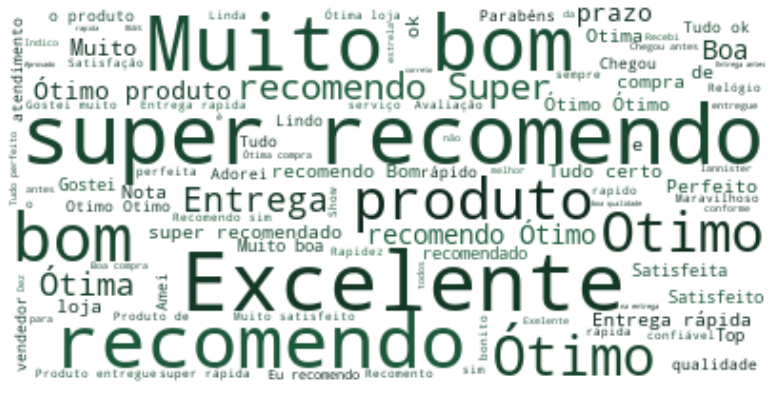

In [160]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
#ROJO
    #    h = int(0)
#    s = int(100.0)
#    l = int(100.0 * float(np.random.randint(40, 90)) / 255.0)
#Verde
    h = int(150)
    s = int(50)
    l = int(100.0 * float(np.random.randint(30, 70)) / 255.0)



    return "hsl({}, {}%, {}%)".format(h, s, l)
def wordcloud( df, variable ):
    df_filter = df[(df["review_score"]>3)]
    df_filter = df_filter[df_filter[variable].notna()]
    text = ' '.join(df_filter[variable])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    wordcloud.recolor(color_func = random_color_func)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    
wordcloud( df_orders, "review_comment_title")